## Problem Understanding

A bank is interested in predicting which customers are likely to default on loans in advance.It can adjust customer's credit worthiness criteria accordingly and avoid giving out bad loans. It has collected data like credit utilization,age,past delinquency,debt ratio,income etc related to the customer. 

## Data Understanding

![](variable_description.PNG)

## Workflow
+ Clean and Wrangle data to get it in desired format
+ Visualize and understand which factors are more important in predicting delinquency
+ Build models
+ Evaluate models
+ Predict on test set.  
Here I'll be using logistic regression,xgboost, and neural networks to predict delinquency 

In [58]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score,KFold
from sklearn.metrics import f1_score,confusion_matrix,roc_curve,roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
# Dropping the first column since it was a repitition of the index column
df_train=pd.read_csv('cs-training.csv').iloc[:,1:]
df_test=pd.read_csv('cs-test.csv').iloc[:,1:].drop('SeriousDlqin2yrs',axis=1)

df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Data Cleaning

In [3]:
print(f'Training set has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'Test set has {df_test.shape[0]} rows and {df_test.shape[1]} columns')

Training set has 150000 rows and 11 columns
Test set has 101503 rows and 10 columns


In [4]:
# Identifying columns with missing values

np.round(100*df_train.isnull().sum()/len(df_train),2)

SeriousDlqin2yrs                         0.00
RevolvingUtilizationOfUnsecuredLines     0.00
age                                      0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
DebtRatio                                0.00
MonthlyIncome                           19.82
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
NumberOfDependents                       2.62
dtype: float64

It appears monthly income and number od dependents have around 20% and 3% missing values respectively. Imputation strategies need to be decided after looking at the distribution of these variables

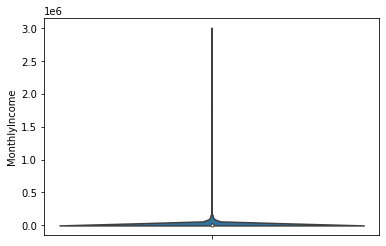

In [5]:
# Visualizing the monthly income column

sns.violinplot(data=df_train,y='MonthlyIncome')

As seen above, monthly income has a very long tail and missing values will be imputed with the median value

In [6]:
# Imputing missing values in the monthly income column with the median income
income_med=df_train['MonthlyIncome'].median()
df_train['MonthlyIncome']=df_train['MonthlyIncome'].fillna(income_med)
df_test['MonthlyIncome']=df_test['MonthlyIncome'].fillna(income_med)

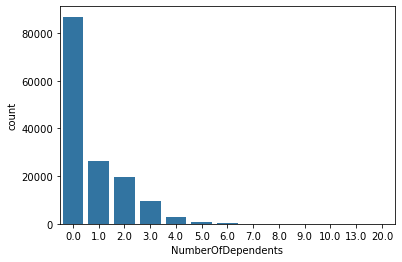

In [7]:
# Visualizing number of dependents 
base_color=sns.color_palette()[0]
sns.countplot(data=df_train,x='NumberOfDependents',color=base_color);

Vast majority of the people have no dependents and hence missing values will be imputed with 0

In [8]:
df_train['NumberOfDependents']=df_train['NumberOfDependents'].fillna(0)
df_test['NumberOfDependents']=df_test['NumberOfDependents'].fillna(0)

## visualizing and understanding data

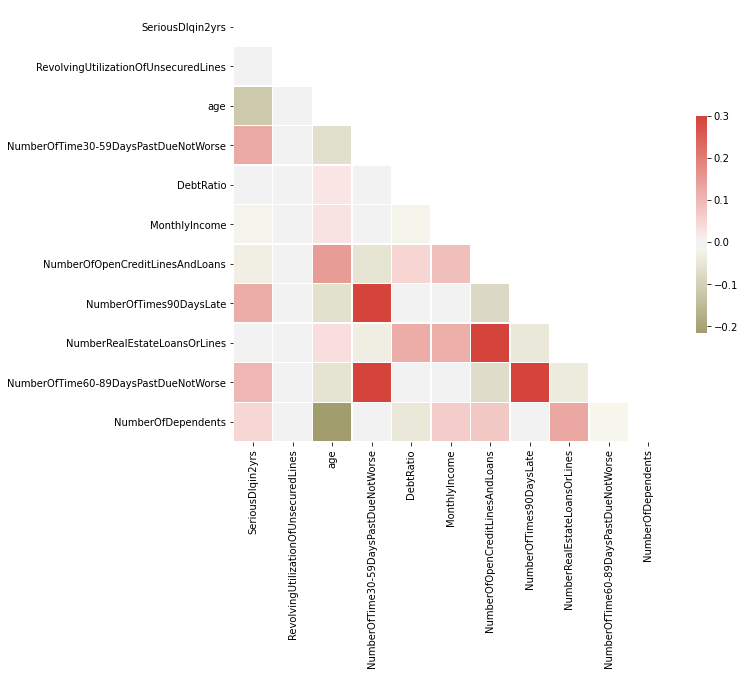

In [9]:
# Calculating the correlation matrix between different variables
corr_matrix=df_train.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(800, 14, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

+ From the above heatmap it is evident that NumberofDependants, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse and age are the most important factors in predicting possibility of delinquency.  
  
  
+ Past delinquency records,number of dependents and  a person's age are determining factors to predict delinquency

In [10]:
def plot_multiple(col_names,m=3,n=2):
    base_color=sns.color_palette()[0]
    i=1
    for col in col_names:
        fig=plt.subplot(m,n,i)
        fig.xaxis.set_ticklabels([])
        sns.violinplot(data=df_train,y=col,x='SeriousDlqin2yrs',color=base_color)
        i+=1

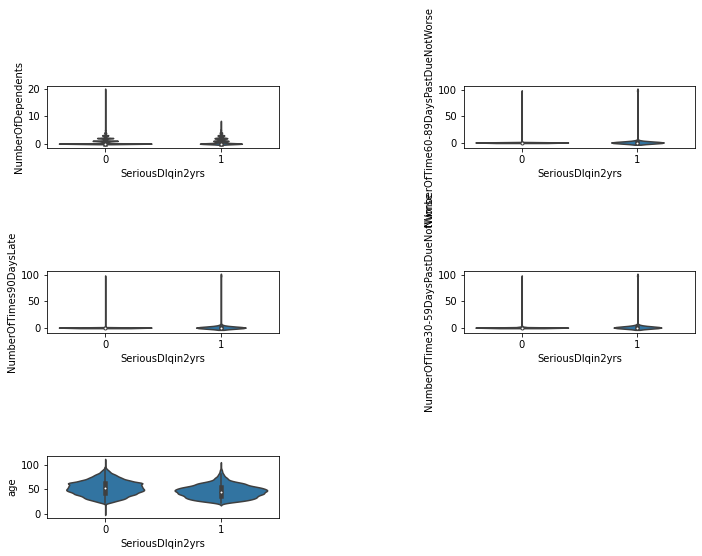

In [11]:
# Plotting the more correlated variables against the default column

df_train['SeriousDlqin2yrs']=df_train['SeriousDlqin2yrs'].astype('category')
base_color=sns.color_palette()[0]

cols_to_plot=['NumberOfDependents','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate',
             'NumberOfTime30-59DaysPastDueNotWorse','age']

plot_multiple(cols_to_plot)
    
plt.subplots_adjust(right=1.5,top=1.5,left=0,bottom=0,wspace=0.8,hspace=2)


+ It appears that people with more than 10 dependents are less likely to default. 
+ people who default tend to delay their payments
+ Although the difference is small, younger people tend to default more

In [12]:
#resetting matplotlib plotting parameters
mpl.rcParams.update(mpl.rcParamsDefault)

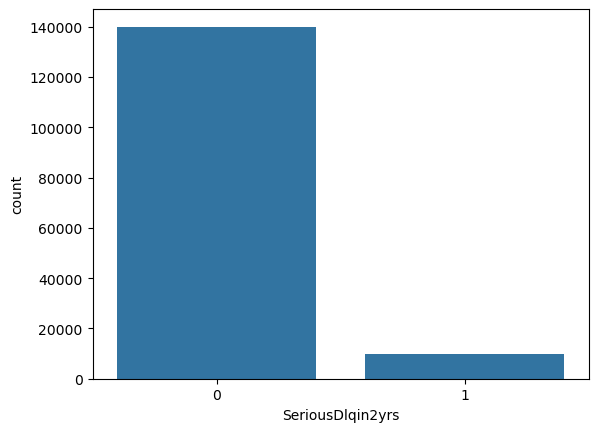

In [13]:
 # Plotting distribution of the target column
sns.countplot(data=df_train,x='SeriousDlqin2yrs',color=base_color);

There is class imbalance in this dataset and data needs to be upsampled to properly predict delinquency

## Model Building

#### Upsampling

In [14]:

X,y=df_train.drop('SeriousDlqin2yrs',axis=1),df_train['SeriousDlqin2yrs']
sm=SMOTE(random_state=21)
X1,y1=sm.fit_resample(X,y)

In [15]:
y1.value_counts()

1    139974
0    139974
Name: SeriousDlqin2yrs, dtype: int64

#### Train-test-split

In [16]:

X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.1,random_state=42)
print('training set',[X_train.shape,y_train.shape])
print('test set',[X_test.shape,y_test.shape])

training set [(251953, 10), (251953,)]
test set [(27995, 10), (27995,)]


In [17]:
sc=StandardScaler()
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)
df_test_scaled=sc.transform(df_test)

#### Logistic regression model

In [18]:
lr1=LogisticRegression()
lr1.fit(X_train_scaled,y_train)
pred=lr1.predict(X_test_scaled)
print('F1 score:',f1_score(y_test,pred))

F1 score: 0.6557838852974105


#### XGBoost Model

In [45]:
# Determining best parameters for the xgboost classifier
# kf=KFold(n_splits=5,shuffle=True,random_state=42)

# params={'max_depth':[3,5,7],
#  'learning_rate':[0.01,0.015,0.02,0.05,0.1],
# 'gamma':[0.05,0.1,0.3],
# 'min_child_weight':[1,3,5],
# 'subsample':[0.6,0.8],
# 'colsample_bytree':[0.6,0.8],
# 'reg_alpha':[0.01,0.1,0.5,1,3],
# 'reg_lambda':[0.1,0.5,1]}

# xgb=XGBClassifier(n_jobs=-1,random_state=42)

# xgb_grid=RandomizedSearchCV(xgb,params,scoring='f1',cv=kf)

# start_time=time.time()
# xgb_grid.fit(X_train_scaled,y_train)
# print('Training time:',time.time()-start_time)

Training time: 358.93985652923584


0.8787900927887777

In [49]:
# Training a model with the best parameters
xgb1=XGBClassifier(subsample=0.8,reg_lambda=0.5,
                  reg_alpha=1,min_child_weight=5,
                  max_depth=7,learning_rate=0.1,
                  gamma=0.05,colsample_bytree=0.8)

xgb1.fit(X_train_scaled,y_train)
pred=xgb1.predict(X_test_scaled)
print('F1 score:',f1_score(y_test,pred))


F1 score: 0.8775331041041773


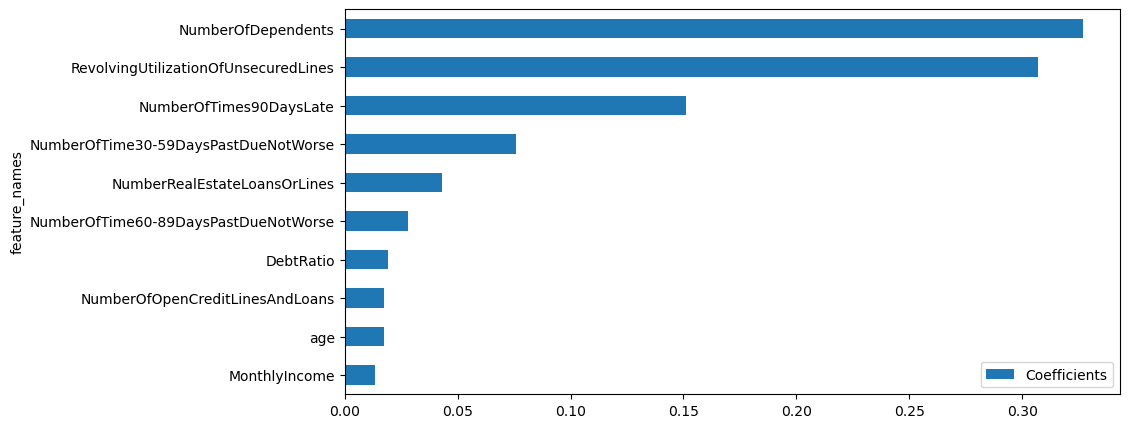

In [51]:
# Feature importances
f_importances=pd.DataFrame()
f_importances['feature_names']=X_train.columns
f_importances['Coefficients']=xgb1.feature_importances_
f_importances=f_importances.sort_values(by='Coefficients',ascending=True).set_index('feature_names')
f_importances.plot.barh(figsize=(10,5));

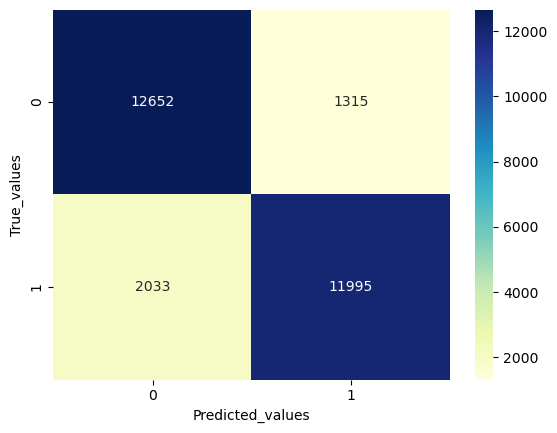

In [55]:
# Confusion Matrix
conf=confusion_matrix(y_test,pred)
sns.heatmap(conf,xticklabels=['0','1'],yticklabels=['0','1'],annot=True,fmt='d',cmap='YlGnBu')
plt.xlabel('Predicted_values')
plt.ylabel('True_values');

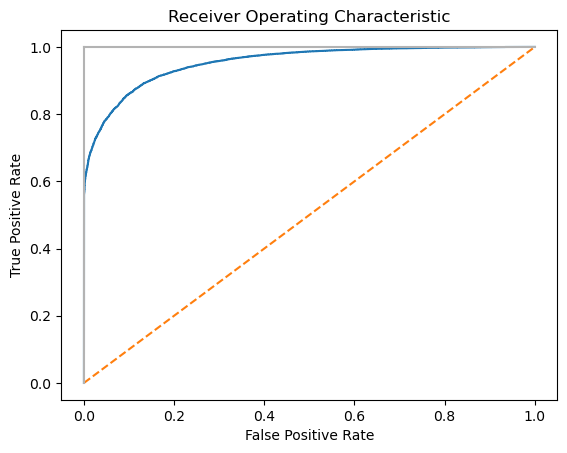

In [61]:
# ROC-AUC curve
pred_proba=xgb1.predict_proba(X_test_scaled)[:,1]
fpr,tpr,thresh=roc_curve(y_test,pred_proba)

# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate");